# Dim = 10


In [53]:
import numpy as np
# import GPUtil
# Get the parent folder path (folder K)
import sys
import os
parent_folder_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

print(parent_folder_path)

folder_classes_path = os.path.join(parent_folder_path, 'classes')
sys.path.append(folder_classes_path)
from entropic_iterative_scheme import save_data, W2_pot
import pandas as pd

from true_WB import *
from input_generate_plugin import *
from entropic_estimate_OT import *
from entropic_iterative_scheme import *
from config_log import *
from measure_visualize import *
from input_generate_entropy import *
from sample_plot import *

import pickle

import tqdm


/Users/zeyichen/Github/Repo/WB_Algo/WIN_Korotin


In [22]:
dim = 10
num_samples = 5000
num_measures = 10
iter = 0
truncated_radius = 5000
seed = 1009

In [23]:
source_sampler = MixtureOfGaussians(dim)
source_sampler.random_components(num_components=5, uniform_weights = True, seed = seed) # seed from the measure selection
# source_sampler.set_truncation(truncated_radius)

In [24]:
auxiliary_measure_sampler_set = []
for auxiliary_seed in range(10):
    auxiliary_measure_sampler = MixtureOfGaussians(dim)
    auxiliary_measure_sampler.random_components(num_components=5, uniform_weights = True, seed = auxiliary_seed * 100)
    # auxiliary_measure_sampler.set_truncation(truncated_radius)
    auxiliary_measure_sampler_set.append(auxiliary_measure_sampler)

In [25]:
# construct entropic_sampler
entropic_sampler = entropic_input_sampler(dim, 
                                          num_measures, 
                                          auxiliary_measure_sampler_set, 
                                          source_sampler = source_sampler, 
                                          n_k = 1000, 
                                          seed = 120, 
                                          gamma = 0.3, 
                                          manual = False,
                                          truncated_radius = truncated_radius,
                                          bound_type = "norm_bound")


In [26]:
result_dir = f"results/WIN_measures_{num_measures}_seed_{seed}_samples_{num_samples}_dim_{dim}"
os.makedirs(result_dir, exist_ok=True)
save_pathname = f"{result_dir}/input_and_source_samples"
plot_dirc = f"{save_pathname}/plots"
os.makedirs(plot_dirc, exist_ok=True)
csv_dirc = f"{save_pathname}/csv_files"
os.makedirs(csv_dirc, exist_ok=True)
# Load the sampler attributes from pkl files (only when the entropic_sampler has been set up)
with open(f"{result_dir}/entropic_sampler_info.pkl", "rb") as f:
    loaded_data_entropic_sampler = pickle.load(f)

with open(f"{result_dir}/source_sampler_info.pkl", "rb") as f:
    loaded_data_source_sampler = pickle.load(f)

print("Loaded Data for Entropic Sampler:", loaded_data_entropic_sampler)
print("Loaded Data for Source Sampler:", loaded_data_source_sampler)

Loaded Data for Entropic Sampler: {'dim': 10, 'num_measures': 10, 'auxiliary_measure_sampler_set': [<true_WB.MixtureOfGaussians object at 0x1b1f52110>, <true_WB.MixtureOfGaussians object at 0x1afbef1d0>, <true_WB.MixtureOfGaussians object at 0x1b1e50810>, <true_WB.MixtureOfGaussians object at 0x1b1e50f90>, <true_WB.MixtureOfGaussians object at 0x1b1e53e10>, <true_WB.MixtureOfGaussians object at 0x1b1f5bed0>, <true_WB.MixtureOfGaussians object at 0x1b1f59d50>, <true_WB.MixtureOfGaussians object at 0x1b1f5a050>, <true_WB.MixtureOfGaussians object at 0x1b1e9d490>, <true_WB.MixtureOfGaussians object at 0x1b1b9d510>], 'tilde_K': 10, 'source_sampler': <true_WB.MixtureOfGaussians object at 0x1b1b9c390>, 'n_k': 1000, 'seed': 120, 'rng_entropy': RandomState(MT19937) at 0x1B1CB2A40, 'gamma': 0.3, 'manual': False, 'truncated_radius': 5000, 'bound_type': 'norm_bound', 'grid_size': 200, 'strong_convexity_param_dict': {0: 0.0001, 1: 0.0001, 2: 0.0001, 3: 0.0001, 4: 0.0001, 5: 0.0001, 6: 0.0001, 7: 0

In [27]:
source_sampler = MixtureOfGaussians(dim)
source_sampler.__dict__.update(loaded_data_source_sampler)

entropic_sampler = entropic_input_sampler(dim, num_measures, auxiliary_measure_sampler_set, source_sampler = source_sampler, n_k = 1000, seed = 120)
entropic_sampler.__dict__.update(loaded_data_entropic_sampler)

# Load the models

In [28]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm, tqdm_notebook

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import os, sys
sys.path.append("..")

import torch
from torch import nn
from torch.nn import functional as F

from scipy.stats import ortho_group
from scipy.linalg import sqrtm

from src.icnn import DenseICNN_U
from src.plotters import plot_training_phase
from src.tools import ewma, score_gen, freeze, unfreeze
from src.fid_score import calculate_frechet_distance
from src import distributions
from src import bar_benchmark
import itertools

import gc
from sklearn.decomposition import PCA

from copy import deepcopy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
dim = 10
assert dim > 1

GPU_DEVICE = 0 # GPU index starting from 0
BATCH_SIZE = 1024

LAMBDA = 10
G_LR = 1e-4
D_LR = 1e-3
MAX_ITER = 50001

D_ITERS = 50
T_ITERS = 10
G_ITERS = 50

PLOT_FREQ = 499
SCORE_FREQ = 499

# Parameters for input distributions
NUM = 10 # we have 10 input measures
ALPHAS = np.array([1. / NUM for _ in range(NUM)])

CASE = {
    'type' : 'EigWarp', 
    'sampler' : 'Rectangles', #'Gaussians', #'SwissRoll',# , #
    'params' : {'num' : NUM, 'alphas' : ALPHAS, 'min_eig' : .5, 'max_eig' : 2}
}


OUTPUT_SEED = 0xBADBEEF

In [30]:
# For now dim_Z = dim_X
Z_sampler = distributions.StandardNormalSampler(dim=dim, device = 'cpu') #.cuda()
G = nn.Sequential(
    nn.Linear(dim, max(100, 2*dim)),
    nn.ReLU(True),
    nn.Dropout(0.005),
    nn.Linear(max(100, 2*dim), max(100, 2*dim)),
    nn.ReLU(True),
    nn.Dropout(0.005),
    nn.Linear(max(100, 2*dim), max(100, 2*dim)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*dim), dim)
).cpu()

In [31]:
# test
model_path = f"{result_dir}/trained_models_iter_{9900}.pth"
try:
    # First try with automatic device selection
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = torch.load(model_path, map_location=device)
    G.load_state_dict(checkpoint["G"])
    G.to(device)
except AssertionError:
    # Fall back to CPU if CUDA is not properly configured
    print("CUDA not available, using CPU instead")
    checkpoint = torch.load(model_path, map_location='cpu')
    G.load_state_dict(checkpoint["G"])
    G.to('cpu')

Z = Z_sampler.sample(1000).cpu()
G.eval()
X = G(Z).detach().numpy()
len(X[0])

10

In [32]:
csv_dirc = f"{result_dir}/input_and_source_samples/csv_files"
os.makedirs(csv_dirc, exist_ok=True)
V_values_dict = {}
W2_to_true_bary_dict = {}

In [ ]:
############### freeze ##################
for it in range(2750, 40000, 2750):  
    iter_V_value_dict = {}
    iter_W2_sq_dict = {}
    model_path = f"{result_dir}/trained_models_iter_{it}.pth"
    
    if os.path.exists(model_path):
        print(f"Loading model from iteration {it}...")
        
        try:
            # First try with automatic device selection
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            checkpoint = torch.load(model_path, map_location=device)
            G.load_state_dict(checkpoint["G"])
            G.to(device)
        except AssertionError:
            # Fall back to CPU if CUDA is not properly configured
            print("CUDA not available, using CPU instead")
            checkpoint = torch.load(model_path, map_location='cpu')
            G.load_state_dict(checkpoint["G"])
            G.to('cpu')

        G.eval()

        for i in tqdm(range(20), desc=f"Iteration {it}"):
            Z = Z_sampler.sample(5000)
            X = G(Z).detach().numpy()

            V_value = 0
            for measure_index in range(num_measures):
                input_measure_samples = pd.read_csv(f"{csv_dirc}/input_measure_samples_{measure_index}.csv", header = None)
                input_samples = np.array(input_measure_samples)
                input_samples = input_samples[np.random.choice(input_samples.shape[0], size=num_samples, replace=False)]
                V_value += W2_pot(input_samples, X)
            # normalize the V_value by the number of input measures
            V_value /= num_measures
            iter_V_value_dict[f"MCSample_{i}"] = V_value

            bary_samples = pd.read_csv(f"{csv_dirc}/true_barycenter_samples.csv", header = None).sample(n = num_samples).reset_index(drop=True).to_numpy()
            W2_sq = W2_pot(X, bary_samples)
            iter_W2_sq_dict[f"MCSample_{i}"] = W2_sq
        
    V_values_dict[f"iter_{it}"] = iter_V_value_dict
    W2_to_true_bary_dict[f"iter_{it}"] = iter_W2_sq_dict

    V_value_dir = f"{result_dir}/V_values"
    os.makedirs(V_value_dir, exist_ok=True)
    save_data(V_values_dict, V_value_dir, f"V_values_MC.json")
    
    W2_to_true_bary_dir = f"{result_dir}/W2_to_true_bary"
    os.makedirs(W2_to_true_bary_dir, exist_ok=True)
    save_data(W2_to_true_bary_dict, W2_to_true_bary_dir, f"W2_to_true_bary_MC.json")
        

Loading model from iteration 2750...


Iteration 2750: 100%|██████████| 20/20 [18:52<00:00, 56.61s/it]


Loading model from iteration 5500...


Iteration 5500: 100%|██████████| 20/20 [18:39<00:00, 55.96s/it]


Loading model from iteration 8250...


Iteration 8250: 100%|██████████| 20/20 [18:33<00:00, 55.65s/it]


Loading model from iteration 11000...


Iteration 11000: 100%|██████████| 20/20 [18:28<00:00, 55.42s/it]


Loading model from iteration 13750...


Iteration 13750: 100%|██████████| 20/20 [17:44<00:00, 53.22s/it]


Loading model from iteration 16500...


Iteration 16500: 100%|██████████| 20/20 [17:36<00:00, 52.80s/it]


Loading model from iteration 19250...


Iteration 19250: 100%|██████████| 20/20 [17:55<00:00, 53.76s/it]


Loading model from iteration 22000...


Iteration 22000: 100%|██████████| 20/20 [17:37<00:00, 52.88s/it]


Loading model from iteration 24750...


Iteration 24750: 100%|██████████| 20/20 [17:40<00:00, 53.05s/it]


Loading model from iteration 27500...


Iteration 27500: 100%|██████████| 20/20 [17:26<00:00, 52.31s/it]


Loading model from iteration 30250...


Iteration 30250: 100%|██████████| 20/20 [17:32<00:00, 52.64s/it]


Loading model from iteration 33000...


Iteration 33000: 100%|██████████| 20/20 [17:43<00:00, 53.16s/it]


Loading model from iteration 35750...


Iteration 35750: 100%|██████████| 20/20 [17:22<00:00, 52.11s/it]


Loading model from iteration 38500...


Iteration 38500: 100%|██████████| 20/20 [17:45<00:00, 53.29s/it]


In [37]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


# Load the JSON files
with open(f"{V_value_dir}/V_values_MC.json", "r") as file1:
    v_data_dim10 = json.load(file1)

with open(f"{W2_to_true_bary_dir}/W2_to_true_bary_MC.json", "r") as file2:
    w2_data_dim10 = json.load(file2)

In [45]:
with open(f"{result_dir}/true_V_values_dim10.pkl", "rb") as f:
    true_v_value_record_dim10 = np.array(pickle.load(f)[:20])
# Calculate statistics for true_V_values
trim_pct = 0.1
k = int(len(true_v_value_record_dim10) * trim_pct)
true_v_value_record_dim10_sorted = np.sort(true_v_value_record_dim10)
true_v_value_record_dim10_trimmed = true_v_value_record_dim10_sorted[k:-k]
mean_true_V_dim10 = np.mean(true_v_value_record_dim10_trimmed)
lb_dim10, ub_dim10 = np.quantile(true_v_value_record_dim10_trimmed, [0.25, 0.75])
print(f"True V value: {mean_true_V_dim10} [{lb_dim10}, {ub_dim10}]")

True V value: 8961.617707197536 [8956.51144885904, 8967.15811316846]


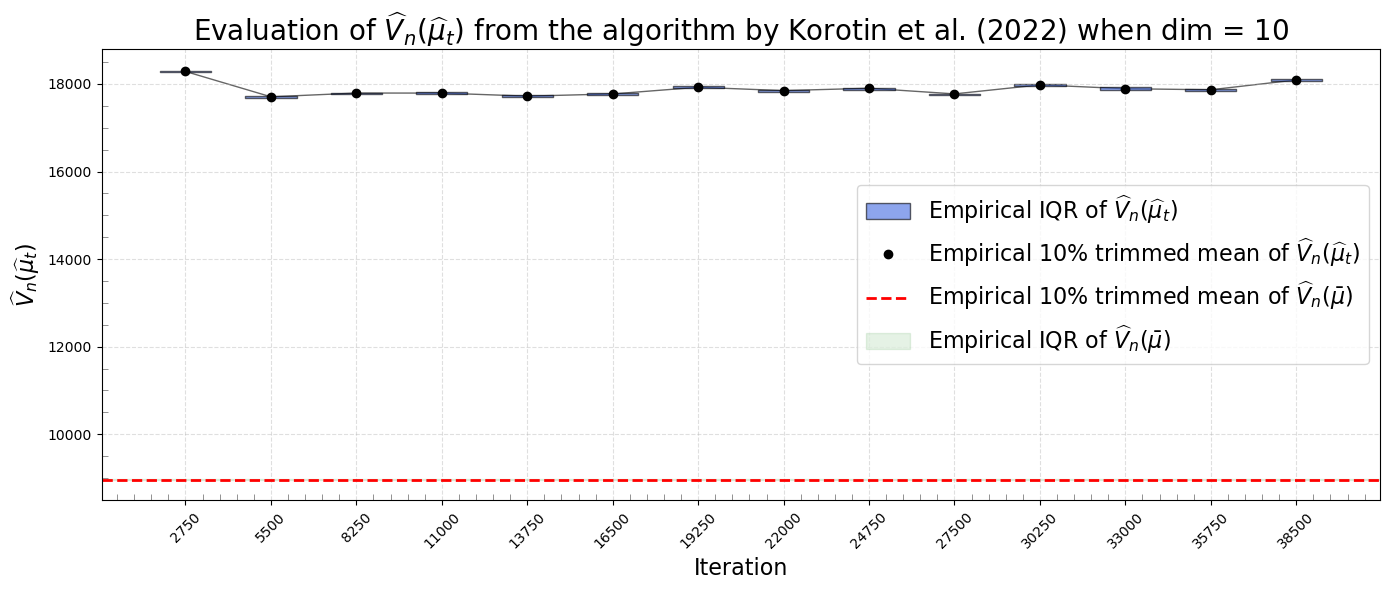

In [56]:
trim_pct = 0.1
sorted_epochs = sorted(v_data_dim10.keys(), key=lambda x: int(x.split("_")[1]))

plt.figure(figsize=(14, 6))
trimmed_means = []

for i, epoch in enumerate(sorted_epochs):
    values = np.array(list(v_data_dim10[epoch].values()))
    n = len(values)
    k = int(n * trim_pct)
    sorted_vals = np.sort(values)
    trimmed_vals = sorted_vals[k:-k] if k > 0 else sorted_vals

    # Stats
    trimmed_mean = np.mean(trimmed_vals)
    lower_quantile = np.quantile(trimmed_vals, 0.25)
    upper_quantile = np.quantile(trimmed_vals, 0.75)
    min_val = np.min(trimmed_vals)
    max_val = np.max(trimmed_vals)

    box_width = 0.6

    # Draw "whiskers" from min to max
    plt.plot([i, i], [min_val, max_val], color='black', linewidth=1)

    # Only label the first box so legend doesn't repeat
    label = r'Empirical IQR of $\widehat{V}_n(\widehat{\mu}_t)$' if i == 0 else None

    plt.fill_between([i - box_width/2, i + box_width/2],
                    lower_quantile, upper_quantile,
                    color='royalblue', alpha=0.6,
                    edgecolor='black', linewidth=1,
                    label=label)

    # Draw trimmed mean
    plt.plot(i, trimmed_mean, 'o', color='black', markersize=6, label=r'Empirical 10% trimmed mean of $\widehat{V}_n(\widehat{\mu}_t)$' if i == 0 else "")
    trimmed_means.append(trimmed_mean)

plt.plot(range(len(sorted_epochs)), trimmed_means,
         color='black', linestyle='-', linewidth=1, alpha=0.6, zorder=0)
# Style
# Plot horizontal reference line for mean_true_V
plt.axhline(mean_true_V_dim10, color='red', linestyle='--', linewidth=2, label=r'Empirical 10% trimmed mean of $\widehat{V}_n(\bar{\mu})$')

# Add shaded confidence band between lb and ub
# plt.ylim(5000, 8500)
plt.axhspan(lb_dim10, ub_dim10, color='green', alpha=0.1, label=r'Empirical IQR of $\widehat{V}_n(\bar{\mu})$')
plt.xticks(ticks=range(len(sorted_epochs)), labels=[int(e.split('_')[1]) for e in sorted_epochs], rotation=45)
plt.xlabel("Iteration", fontsize = 16)
plt.ylabel(r"$\widehat{V}_n(\widehat{\mu}_t)$", fontsize = 16)
plt.title(r"Evaluation of $\widehat{V}_n(\widehat{\mu}_t)$ from the algorithm by Korotin et al. (2022) when dim = 10", fontsize = 20)
plt.legend(fontsize = 16)
# Add minor ticks
ax = plt.gca()
ax.minorticks_on()
ax.tick_params(axis='both', which='minor', length=4, color='gray', direction='in')

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig(f"{result_dir}/V_values_convergence_WIN.png")
plt.show()


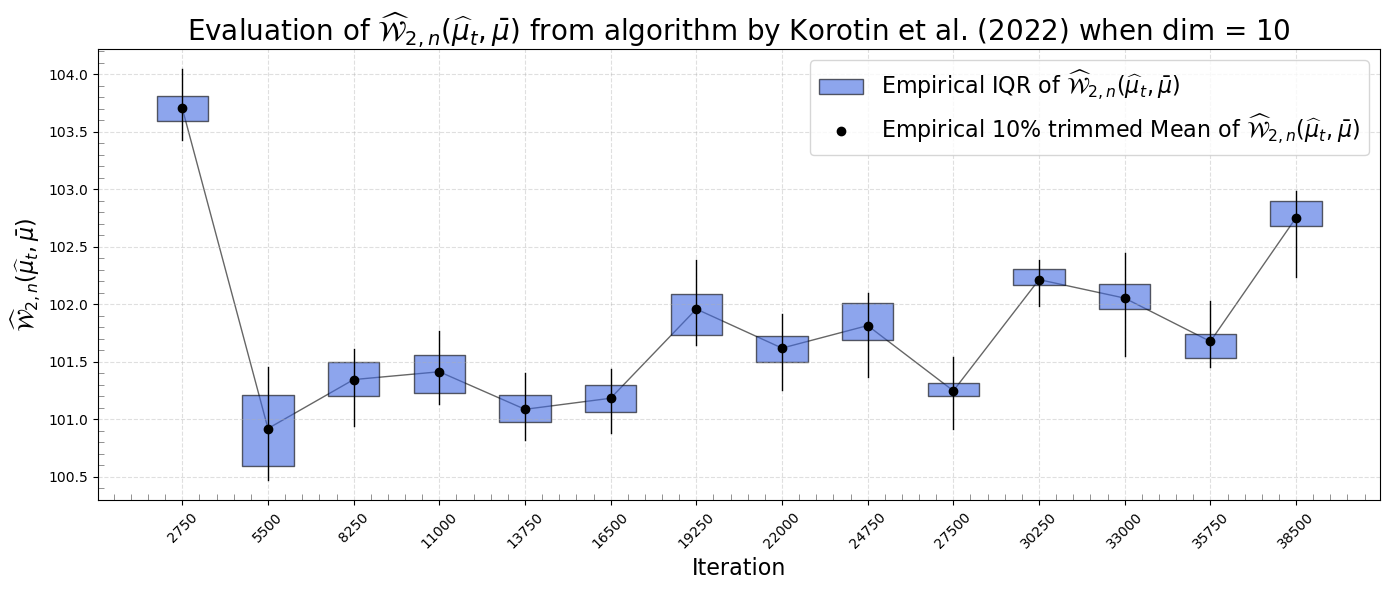

In [57]:
trim_pct = 0.1
sorted_epochs = sorted(w2_data_dim10.keys(), key=lambda x: int(x.split("_")[1]))

plt.figure(figsize=(14, 6))
trimmed_means = []
# Flatten all values from all epochs into one array
all_values = np.concatenate([list(w2_data_dim10[epoch].values()) for epoch in sorted_epochs])
min_achieved = np.min(all_values)


for i, epoch in enumerate(sorted_epochs):
    values = np.array(list(w2_data_dim10[epoch].values()))
    values = np.sqrt(values)  # Take the square root of the values
    n = len(values)
    k = int(n * trim_pct)
    sorted_vals = np.sort(values)
    trimmed_vals = sorted_vals[k:-k] if k > 0 else sorted_vals

    # Stats
    trimmed_mean = np.mean(trimmed_vals)
    lower_quantile = np.quantile(trimmed_vals, 0.25)
    upper_quantile = np.quantile(trimmed_vals, 0.75)
    min_val = np.min(trimmed_vals)
    max_val = np.max(trimmed_vals)

    box_width = 0.6

    # Draw "whiskers" from min to max
    plt.plot([i, i], [min_val, max_val], color='black', linewidth=1)

    # Only label the first box so legend doesn't repeat
    label = r'Empirical IQR of $\widehat{\mathcal{W}}_{2, n}(\widehat{\mu}_t, \bar{\mu})$' if i == 0 else None

    plt.fill_between([i - box_width/2, i + box_width/2],
                    lower_quantile, upper_quantile,
                    color='royalblue', alpha=0.6,
                    edgecolor='black', linewidth=1,
                    label=label)

    # Draw trimmed mean
    plt.plot(i, trimmed_mean, 'o', color='black', markersize=6, label=r'Empirical 10% trimmed Mean of $\widehat{\mathcal{W}}_{2, n}(\widehat{\mu}_t, \bar{\mu})$' if i == 0 else "")
    trimmed_means.append(trimmed_mean)

plt.plot(range(len(sorted_epochs)), trimmed_means,
         color='black', linestyle='-', linewidth=1, alpha=0.6, zorder=0)
# plt.axhline(min_achieved, color='red', linestyle='--', linewidth=2,
#             label=r'Minimum $\widehat{\mathcal{W}}_{2, n}(\widehat{\mu}_t, \bar{\mu})^2$ across epochs')
# # Add a label (adjust x-position if needed)
# plt.text(0, min_achieved,
#          f"{min_achieved:.2f}",  # format to 2 decimals
#          color='red', fontsize=10, va='bottom')

# Style
# Plot horizontal reference line for mean_true_V
# plt.axhline(mean_true_V, color='red', linestyle='--', linewidth=2, label=r'Empirical mean of $\widehat{V}_n(\bar{\mu})$')

# # Add shaded confidence band between lb and ub
# plt.axhspan(lb, ub, color='mediumseagreen', alpha=0.1, label=r'Empirical 90% central interval of $\widehat{V}_n(\bar{\mu})$')
plt.xticks(ticks=range(len(sorted_epochs)), labels=[int(e.split('_')[1]) for e in sorted_epochs], rotation=45)
plt.xlabel("Iteration", fontsize = 16)
plt.ylabel(r"$\widehat{\mathcal{W}}_{2, n}(\widehat{\mu}_t, \bar{\mu})$", fontsize = 16)
plt.title(r"Evaluation of $\widehat{\mathcal{W}}_{2, n}(\widehat{\mu}_t, \bar{\mu})$ from algorithm by Korotin et al. (2022) when dim = 10", fontsize = 20)
plt.legend(fontsize = 16)
# Add minor ticks
ax = plt.gca()
ax.minorticks_on()
ax.tick_params(axis='both', which='minor', length=4, color='gray', direction='in')

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig(f"{result_dir}/W2_to_bary_convergence_WIN.png")
plt.show()
